In [16]:
import pandas as pd
from pyinaturalist import *
import inspect
#from pyinaturalist_convert import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import datetime
from dateutil.tz import tzutc, tzoffset
import geopandas as gpd
from tqdm.notebook import tqdm
tqdm.pandas()

In [17]:
# import nztcs_export.xlsx
nz_stats = pd.read_excel('nztcs_export.xlsx')
print(nz_stats.columns)

/Users/ekoskova/Library/Python/3.9/lib/python/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Index(['Report Name', 'Preferred Common Name', 'Preferred Māori Name',
       'Assessment Name and Authority', 'Current Name and Authority',
       'Current Species Name', 'Category', 'Status', 'Criteria', 'Pop State',
       'Pop Size', 'Size Confidence', 'Pop Trend', 'Time Span (years)',
       'Trend Confidence', 'Qualifiers', 'Status Change', 'Change Reason',
       'Assessment ID', 'Report ID', 'Report Year', 'Report Edit Status',
       'Report Published Status', 'Assessment Edit Status', 'Species ID',
       'Alternative Names', 'Genus', 'Family', 'Order', 'Class', 'Phylum',
       'Kingdom', 'Previous Name', 'Previous Category', 'Previous Status',
       'Previous Report Year', 'Changed Name', 'Taxonomic Status',
       'Bio Status', 'Environment', 'NZOR ID', 'CD', 'CI', 'CR', 'De', 'DP',
       'DPR', 'DPS', 'DPT', 'EF', 'EW', 'HI', 'IE', 'Inc', 'NO', 'NS', 'OL',
       'PD', 'PE', 'PF', 'RC', 'Rel', 'RF', 'RR', 'S?O', 'SO', 'SO?', 'Sp',
       'St', 'T?O', 'TO', 'TO?'],
     

In [6]:
# print all unique values of Stauts
print(nz_stats['Status'].unique())

['Data Deficient' 'Not Threatened' 'Relict' 'Declining'
 'Naturally Uncommon' 'Nationally Vulnerable' 'Nationally Endangered'
 'Nationally Critical' 'Introduced and Naturalised' 'Recovering' 'Vagrant'
 'Extinct' 'Not assessed' 'Nationally Increasing' 'Coloniser'
 'Taxonomically indistinct' 'Migrant' 'Sparse' 'Gradual Decline'
 'Not listed' 'Serious Decline' 'Range Restricted']


In [7]:
# import inat_nz.csv
inat_nz = pd.read_csv('inat_nz.csv', delimiter='\t', encoding='utf-8')
print(inat_nz)

             gbifID                            datasetKey  \
0        1990598370  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1        2237479673  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
2        2269256337  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
3        2269289954  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
4        2422945129  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
...             ...                                   ...   
1266927  2236867469  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1266928  2239041061  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1266929  2251897164  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1266930  2422962432  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1266931  2445162324  50c9509d-22c7-4a22-a47d-8c48425ef4a7   

                                              occurrenceID   kingdom  \
0        https://www.inaturalist.org/observations/19900806   Plantae   
1        https://www.inaturalist.org/observations/22863983     Fungi   
2        https://www.inaturalist.org/observations/2

In [18]:
# Get the counts of each scientific name
species_counts_inat = inat_nz['scientificName'].value_counts()

# Reset index to convert the series to a DataFrame
species_counts_inat = species_counts_inat.reset_index()

# Rename columns to appropriate names
species_counts_inat.columns = ['scientificName', 'count']

# Add the 'class' column
species_counts_inat['class'] = inat_nz.groupby('scientificName')['class'].first().values

species_counts_inat['kingdom'] = inat_nz.groupby('scientificName')['kingdom'].first().values
species_counts_inat['order'] = inat_nz.groupby('scientificName')['order'].first().values
# Add the 'phylum' column
species_counts_inat['phylum'] = inat_nz.groupby('scientificName')['phylum'].first().values

# Get only the first two words of the scientific name
species_counts_inat['scientificName'] = species_counts_inat['scientificName'].str.split().str[:2].str.join(' ')

# Drop duplicates
species_counts_inat = species_counts_inat.drop_duplicates()
species_counts_inat['class'].fillna('Actinopterygii', inplace=True)
# Reset index
species_counts_inat = species_counts_inat.reset_index(drop=True)

# Display the tail of the DataFrame
print(species_counts_inat.tail())


             scientificName  count            class  kingdom  \
15703               Anu una      1        Bryopsida  Plantae   
15704  Epichloe coenophiala      1  Sordariomycetes    Fungi   
15705   Inocybe horakomyces      1  Sordariomycetes    Fungi   
15706      Rhodocybe gemina      1  Dothideomycetes    Fungi   
15707      Erysiphe azaleae      1    Magnoliopsida  Plantae   

                   order        phylum  
15703     Orthotrichales     Bryophyta  
15704         Xylariales    Ascomycota  
15705         Xylariales    Ascomycota  
15706  Mycosphaerellales    Ascomycota  
15707       Saxifragales  Tracheophyta  


In [19]:
# define the lambda apply_progress function separately to handle exceptions
def find_match(x):
    try:
        return nz_stats[nz_stats['Current Species Name'].str.contains(x, case=False)]['Status'].values[0]
    except:
        return ''

In [20]:
# apply the function to the column
species_counts_inat['status'] = species_counts_inat['scientificName'].progress_apply(find_match)
print(species_counts_inat)


  0%|          | 0/15708 [00:00<?, ?it/s]

                        scientificName  count            class   kingdom  \
0            Hemiphaga novaeseelandiae   9629     Demospongiae  Animalia   
1                  Cordyline australis   4767     Demospongiae  Animalia   
2        Prosthemadera novaeseelandiae   4331     Demospongiae  Animalia   
3      Chroicocephalus novaehollandiae   4226    Magnoliopsida   Plantae   
4                  Ichneutica Meyrick,   4093          Insecta  Animalia   
...                                ...    ...              ...       ...   
15703                          Anu una      1        Bryopsida   Plantae   
15704             Epichloe coenophiala      1  Sordariomycetes     Fungi   
15705              Inocybe horakomyces      1  Sordariomycetes     Fungi   
15706                 Rhodocybe gemina      1  Dothideomycetes     Fungi   
15707                 Erysiphe azaleae      1    Magnoliopsida   Plantae   

                   order        phylum          status  
0             Suberitida      

/var/folders/kt/v_6ktp0n0r3fpjjtvr2gsdnc0000gp/T/ipykernel_2438/3988510288.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return nz_stats[nz_stats['Current Species Name'].str.contains(x, case=False)]['Status'].values[0]


In [21]:
# Replace empty strings with 'Unknown' in the 'status' column
species_counts_inat['status'] = species_counts_inat['status'].replace('', 'Unknown')

# Pivot the dataframe
pivot_table_inat = species_counts_inat.pivot_table(index=['class', 'status', 'phylum', 'kingdom','order'], values='scientificName', aggfunc='nunique').reset_index()

# Rename the 'scientificName' column to 'count'
pivot_table_inat.rename(columns={'scientificName': 'count'}, inplace=True)

# Display the DataFrame
print(pivot_table_inat)

# Filter the DataFrame
filtered_pivot_table_inat = pivot_table_inat[pivot_table_inat['kingdom'] == 'Plantae']

filtered_species_counts_inat = filtered_pivot_table_inat 
# Display the filtered DataFrame
print(filtered_species_counts_inat)

                 class              status            phylum   kingdom  \
0        Actinomycetia             Unknown  Actinobacteriota  Bacteria   
1        Actinomycetia             Unknown  Actinobacteriota  Bacteria   
2       Actinopterygii           Coloniser          Chordata  Animalia   
3       Actinopterygii      Data Deficient          Chordata  Animalia   
4       Actinopterygii      Data Deficient          Chordata  Animalia   
...                ...                 ...               ...       ...   
1699    Zoopagomycetes  Naturally Uncommon     Zoopagomycota     Fungi   
1700    Zoopagomycetes             Unknown     Zoopagomycota     Fungi   
1701  Zygnematophyceae  Naturally Uncommon        Charophyta   Plantae   
1702  Zygnematophyceae      Not Threatened        Charophyta   Plantae   
1703  Zygnematophyceae             Unknown        Charophyta   Plantae   

                 order  count  
0      Actinomycetales      3  
1     Streptomycetales      3  
2          Perc

In [22]:
# Filter the DataFrame
filtered_pivot_table_inat = pivot_table_inat[pivot_table_inat['kingdom'] == 'Plantae']

filtered_species_counts_inat = filtered_pivot_table_inat
# Display the filtered DataFrame
print(filtered_species_counts_inat)

                 class                 status            phylum  kingdom  \
183      Andreaeopsida     Naturally Uncommon         Bryophyta  Plantae   
184      Andreaeopsida         Not Threatened         Bryophyta  Plantae   
185   Anthocerotopsida         Data Deficient  Anthocerotophyta  Plantae   
186   Anthocerotopsida  Nationally Endangered  Anthocerotophyta  Plantae   
187   Anthocerotopsida  Nationally Vulnerable  Anthocerotophyta  Plantae   
...                ...                    ...               ...      ...   
1693       Ulvophyceae                Unknown       Chlorophyta  Plantae   
1694       Ulvophyceae                Unknown       Chlorophyta  Plantae   
1701  Zygnematophyceae     Naturally Uncommon        Charophyta  Plantae   
1702  Zygnematophyceae         Not Threatened        Charophyta  Plantae   
1703  Zygnematophyceae                Unknown        Charophyta  Plantae   

                order  count  
183       Andreaeales      1  
184       Andreaeales    

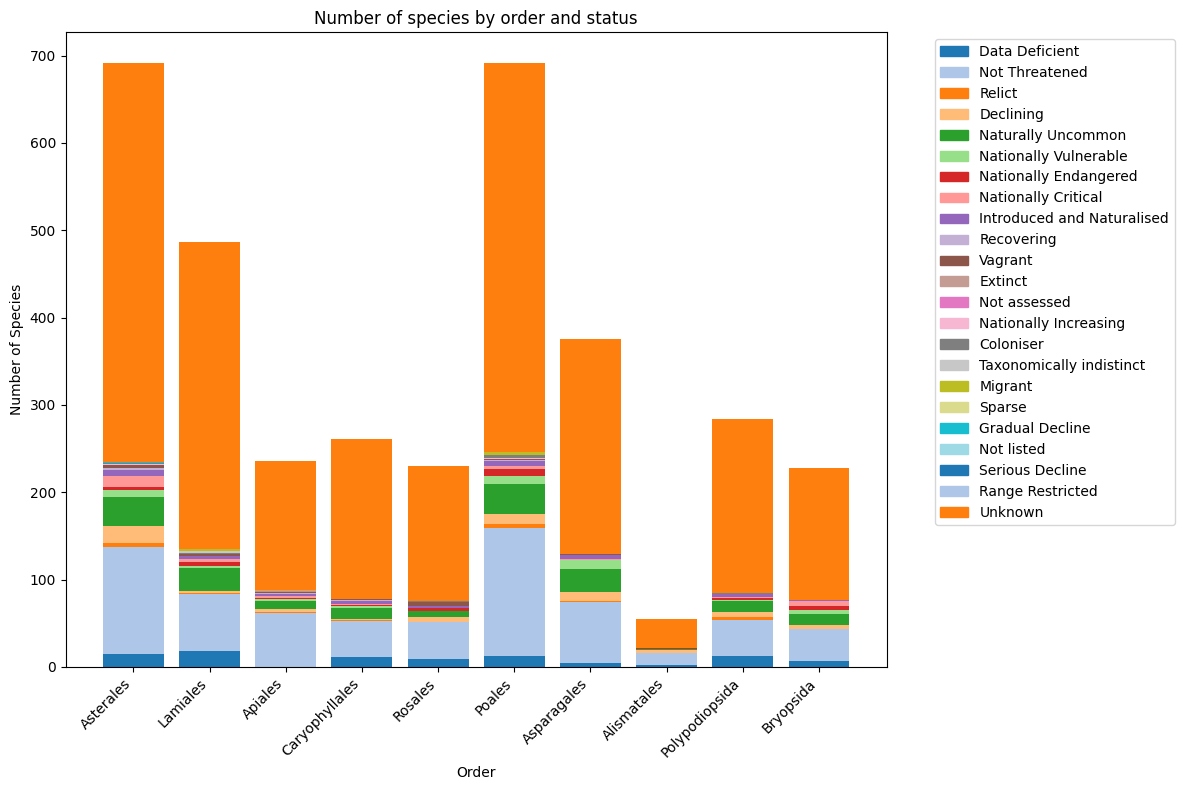

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define the unique status values including "Unknown"
status_values_inat = ['Data Deficient', 'Not Threatened', 'Relict', 'Declining', 'Naturally Uncommon', 
                 'Nationally Vulnerable', 'Nationally Endangered', 'Nationally Critical', 
                 'Introduced and Naturalised', 'Recovering', 'Vagrant', 'Extinct', 'Not assessed', 
                 'Nationally Increasing', 'Coloniser', 'Taxonomically indistinct', 'Migrant', 
                 'Sparse', 'Gradual Decline', 'Not listed', 'Serious Decline', 'Range Restricted', 'Unknown']

# Create a color palette for the statuses
colors_inat = sns.color_palette("tab20", len(status_values_inat))

# Map each status to a color
status_color_map_inat = {status: colors_inat[i] for i, status in enumerate(status_values_inat)}

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Create a color palette for the statuses
colors_inat = sns.color_palette("tab20", len(status_values_inat))

# Map each status to a color
status_color_map_inat = {status: colors_inat[i] for i, status in enumerate(status_values_inat)}

# Filter data for the specified classes and orders
filtered_classes_inat = filtered_species_counts_inat[filtered_species_counts_inat['class'].isin(['Polypodiopsida', 'Bryopsida', 'Magnoliopsida', 'Liliopsida'])]
filtered_classes_inat.loc[filtered_classes_inat['class'] == 'Polypodiopsida', 'order'] = 'Polypodiopsida'
filtered_classes_inat.loc[filtered_classes_inat['class'] == 'Bryopsida', 'order'] = 'Bryopsida'

# Define the selected orders
selected_orders_inat = ['Asterales', 'Lamiales', 'Apiales', 'Caryophyllales', 'Rosales', 'Poales', 'Asparagales', 'Alismatales', 'Polypodiopsida', 'Bryopsida']

# Filter data for selected orders
filtered_classes_inat = filtered_classes_inat[filtered_classes_inat['order'].isin(selected_orders_inat)]

# Iterate over each order
for i, order_name in enumerate(selected_orders_inat):
    order_data = filtered_classes_inat[filtered_classes_inat['order'] == order_name]
    order_data = order_data.reset_index(drop=True)
    
    class_status_counts = order_data.groupby('status')['count'].sum()
    
    # Plot the bar chart for each status within the order
    bottom = 0
    for j, status in enumerate(status_values_inat):
        count = class_status_counts.get(status, 0)
        ax.bar(i, count, bottom=bottom, color=status_color_map_inat.get(status, (0.5, 0.5, 0.5)), label=status)
        bottom += count

    # Add order label to each group of bars
    #ax.text(i, -10, order_name, ha='center', fontsize=12)
    
# Set x-axis ticks and labels
ax.set_xticks(range(len(selected_orders_inat)))
ax.set_xticklabels(selected_orders_inat, rotation=45, ha='right')

# Customize plot
ax.set_title('Number of species by order and status')
ax.set_xlabel('Order')
ax.set_ylabel('Number of Species')

# Create custom legend patches
legend_patches_inat = [Patch(color=status_color_map_inat[status], label=status) for status in status_values_inat]

# Display legend with custom patches
ax.legend(handles=legend_patches_inat, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [24]:
# Get the counts of each scientific name
species_counts = nz_stats['Current Species Name'].value_counts()

# Reset index to convert the series to a DataFrame
species_counts = species_counts.reset_index()

# Rename columns to appropriate names
species_counts.columns = ['Current Species Name', 'count']

# Add the 'class' column
species_counts['Class'] = nz_stats.groupby('Current Species Name')['Class'].first().values

species_counts['Kingdom'] = nz_stats.groupby('Current Species Name')['Kingdom'].first().values
species_counts['Order'] = nz_stats.groupby('Current Species Name')['Order'].first().values
# Add the 'phylum' column
species_counts['Phylum'] = nz_stats.groupby('Current Species Name')['Phylum'].first().values
species_counts['Status'] = nz_stats.groupby('Current Species Name')['Status'].first().values

# Get only the first two words of the scientific name
species_counts['Current Species Name'] = species_counts['Current Species Name'].str.split().str[:2].str.join(' ')

# Drop duplicates
species_counts = species_counts.drop_duplicates()
species_counts['Class'].fillna('Actinopterygii', inplace=True)
# Reset index
species_counts = species_counts.reset_index(drop=True)

# Display the tail of the DataFrame
print(species_counts.tail())


      Current Species Name  count                      Class   Kingdom  \
15003   Gasparia mangamuka      1                  Arachnida  Animalia   
15004  Gasparia manneringi      1                 Gastropoda  Animalia   
15005     Gasparia montana      1                  Bryopsida   Plantae   
15006        Gasparia nava      1  Ascomycota incertae sedis     Fungi   
15007     Zachvatkinia sp.      1                Secernentea  Animalia   

                                 Order      Phylum                      Status  
15003                          Araneae  Arthropoda  Introduced and Naturalised  
15004                  Neotaenioglossa    Mollusca          Naturally Uncommon  
15005                   Orthotrichales   Bryophyta          Naturally Uncommon  
15006  Ascomycota Order incertae sedis  Ascomycota              Data Deficient  
15007                       Tylenchida    Nematoda              Not Threatened  


                  Class          Status         Phylum    Kingdom  \
0        Actinopterygii       Coloniser       Chordata   Animalia   
1        Actinopterygii       Coloniser       Chordata   Animalia   
2        Actinopterygii       Declining       Chordata   Animalia   
3        Actinopterygii       Declining       Chordata   Animalia   
4        Actinopterygii       Declining       Chordata   Animalia   
...                 ...             ...            ...        ...   
1366  Ustilaginomycetes  Data Deficient  Basidiomycota      Fungi   
1367  Xandelariomycetes  Data Deficient     Ascomycota      Fungi   
1368  Xandelariomycetes  Not Threatened     Ascomycota      Fungi   
1369      Xanthophyceae  Data Deficient     Ochrophyta  Chromista   
1370  Xylobotryomycetes  Data Deficient     Ascomycota      Fungi   

               Order  count  
0     Anguilliformes      1  
1        Gobiiformes      2  
2     Anguilliformes      1  
3      Galaxiiformes      6  
4        Gobiiformes 

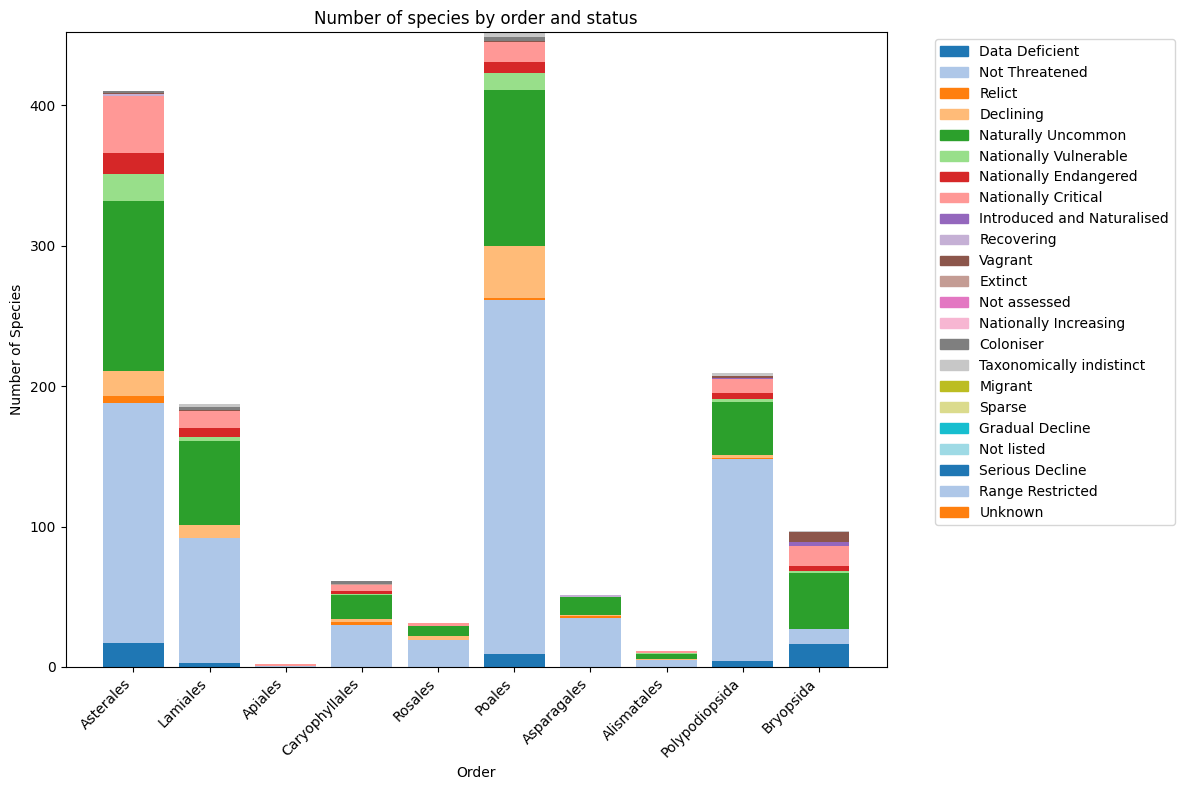

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define the unique status values including "Unknown"
status_values = ['Data Deficient', 'Not Threatened', 'Relict', 'Declining', 'Naturally Uncommon', 
                 'Nationally Vulnerable', 'Nationally Endangered', 'Nationally Critical', 
                 'Introduced and Naturalised', 'Recovering', 'Vagrant', 'Extinct', 'Not assessed', 
                 'Nationally Increasing', 'Coloniser', 'Taxonomically indistinct', 'Migrant', 
                 'Sparse', 'Gradual Decline', 'Not listed', 'Serious Decline', 'Range Restricted', 'Unknown']
# Replace empty strings with 'Unknown' in the 'status' column
species_counts['Status'] = species_counts['Status'].replace('', 'Unknown')

# Pivot the dataframe
pivot_table = species_counts.pivot_table(index=['Class', 'Status', 'Phylum', 'Kingdom','Order'], values='Current Species Name', aggfunc='nunique').reset_index()

# Rename the 'scientificName' column to 'count'
pivot_table.rename(columns={'Current Species Name': 'count'}, inplace=True)

# Display the DataFrame
print(pivot_table)

# Filter the DataFrame
filtered_pivot_table = pivot_table[pivot_table['Kingdom'] == 'Plantae']

filtered_species_counts = filtered_pivot_table 
# Display the filtered DataFrame
print(filtered_species_counts)


# Create a color palette for the statuses
colors = sns.color_palette("tab20", len(status_values))

# Map each status to a color
status_color_map = {status: colors[i] for i, status in enumerate(status_values)}

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Create a color palette for the statuses
colors = sns.color_palette("tab20", len(status_values))

# Map each status to a color
status_color_map = {status: colors[i] for i, status in enumerate(status_values)}

# Filter data for the specified classes and orders
filtered_classes = filtered_species_counts[filtered_species_counts['Class'].isin(['Polypodiopsida', 'Bryopsida', 'Magnoliopsida', 'Liliopsida'])]
filtered_classes.loc[filtered_classes['Class'] == 'Polypodiopsida', 'Order'] = 'Polypodiopsida'
filtered_classes.loc[filtered_classes['Class'] == 'Bryopsida', 'Order'] = 'Bryopsida'

# Define the selected orders
selected_orders = ['Asterales', 'Lamiales', 'Apiales', 'Caryophyllales', 'Rosales', 'Poales', 'Asparagales', 'Alismatales', 'Polypodiopsida', 'Bryopsida']

# Filter data for selected orders
filtered_classes = filtered_classes[filtered_classes['Order'].isin(selected_orders)]

# Iterate over each order
for i, order_name in enumerate(selected_orders):
    order_data = filtered_classes[filtered_classes['Order'] == order_name]
    order_data = order_data.reset_index(drop=True)
    
    class_status_counts = order_data.groupby('Status')['count'].sum()
    
    # Plot the bar chart for each status within the order
    bottom = 0
    for j, status in enumerate(status_values):
        count = class_status_counts.get(status, 0)
        ax.bar(i, count, bottom=bottom, color=status_color_map.get(status, (0.5, 0.5, 0.5)), label=status)
        bottom += count

    # Add order label to each group of bars
    #ax.text(i, -10, order_name, ha='center', fontsize=12)
    
# Set x-axis ticks and labels
ax.set_xticks(range(len(selected_orders)))
ax.set_xticklabels(selected_orders, rotation=45, ha='right')

# Customize plot
ax.set_title('Number of species by order and status')
ax.set_xlabel('Order')
ax.set_ylabel('Number of Species')

# Create custom legend patches
legend_patches = [Patch(color=status_color_map[status], label=status) for status in status_values]

# Display legend with custom patches
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()